In [23]:
import numpy as np
import pandas as pd
import os
from pandas_profiling import ProfileReport 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import os
import re
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn import cluster
from sklearn.ensemble import RandomForestClassifier


#### **依照TITLE 分群**

load data

In [4]:
data_sales = pd.read_csv("sales_data.csv")
login = pd.read_csv("sales_login.csv")
connect = pd.read_csv("sales_connect.csv")
appointment = pd.read_csv("sales_appointment.csv")
memo = pd.read_csv("sales_memo.csv")
questionnaire = pd.read_csv("questionnaire.csv")
cnt = pd.read_csv("cnt.csv")
fyc_lifeinsurance = pd.read_csv("FYC_lifeinsurance.csv")
fyc_propertyinsurance = pd.read_csv("FYC_propertyinsurance.csv")

dataname_list = [data_sales, memo, login, connect, appointment, questionnaire, cnt, fyc_lifeinsurance, fyc_propertyinsurance]
for data in dataname_list:
    data['AGENT_ID'] = data['AGENT_ID'].astype('str')


function

In [5]:
## 業務員資料 start、end取年份
def takeyear(date):
    year = str(date)[:4]
    return year
    
   ## 定聯絡次數
def avg(cnt, num):
    if num != 0:
        avr = round(cnt / num, ndigits = 0)
    else:
        avr = 0   
    return avr

## 職位ordinal編碼
map_agent_title = {#基層
                   'CA':0,'AG':0, 'NCT':0,
                   #行銷主管
                   'CSS':1, 'CMS':1, 'CMD':1, 'CMM':1, 'CMP':1, #服務展業部體系
                   'CS':1, 'CSM':1, 'CDM':1, 'CUM':1, #服務展業部體系
                   'MS':1, 'MAM':1, 'MM':1, 'SMM':1,
                   #業務主管
                   'SP':2, 'AM':2, 'UM':2,
                   #通訊處主管
                   'CUM':3, 'CM':3, 'SCM':3, 'CCM':3, 'CP':3, 'CSP':3, 'CCP':3, 
                   'DM':3, 'VRM':3, 'ARM':3, 'SRM':3, 'AVP':3, 'SVP':3
                  }

memo 資料處理

In [6]:
## MEMO 資料處理
def average(memo, cnt):
    if cnt != 0:
        avr = round(memo / cnt, ndigits = 0)
    else:
        avr = 0   
    return avr
memo = memo.fillna(0)
memo['MEMO_AVERAGE'] = memo.apply(lambda x: average(x['MEMO_LENGTH'], x['CUSTOMER_CNT']), axis = 1)
memo['MEMO_AVERAGE'] = memo['MEMO_AVERAGE'].astype(int)

#memo.info()

將基本資料有缺失的資料刪除

In [7]:
data_sales = data_sales.drop('BIR_DATE', axis = 1)
data_sales = data_sales.dropna()
data_sales['UNIT_POST_CODE'] = data_sales['UNIT_POST_CODE'].astype(int)
data_sales['LOCATION_ID'] = data_sales['LOCATION_ID'].astype(int)

職位ordinal編碼

In [8]:
data_sales['END_DATE'] = data_sales.apply(lambda x: takeyear(x['END_DATE']), axis = 1)
data_sales['START_DATE'] = data_sales.apply(lambda x: takeyear(x['START_DATE']), axis = 1)
data_sales['END_DATE'] = data_sales['END_DATE'].astype(int)
data_sales['START_DATE'] = data_sales['START_DATE'].astype(int)
data_sales['TITLE'] = data_sales['AGENT_TITLE'].replace(map_agent_title)

Login Cnt

In [9]:
login_cnt = pd.DataFrame(login.groupby('AGENT_ID').sum())
login_cnt = login_cnt.reset_index()
login_cnt = login_cnt.drop('YYYYMM', axis = 1)

定聯處理

In [10]:
connect = connect.fillna(0)
connect['CONTACT_CNT_AVG'] = connect.apply(lambda x: avg(x['CONTACT_CNT'], x['CONTACT_CUST_CNT']), axis = 1)
connect['CONTACT_CNT_AVG'] = connect['CONTACT_CNT_AVG'].astype(int)
connect_cnt = pd.DataFrame(connect.groupby('AGENT_ID')[['CONTACT_CNT_AVG', 'CONTACT_CNT', 'CONTACT_CUST_CNT']].sum())
connect_cnt = connect_cnt.reset_index()

In [11]:
## 約訪次數
appointment = appointment.fillna(0)

appointment['CUSTOMER_VISIT_AVG'] = appointment.apply(lambda x: avg(x['VISIT_CNT'], x['CUSTOMER_VISIT_CNT']), axis = 1)
appointment['CUSTOMER_VISIT_AVG'] = appointment['CUSTOMER_VISIT_AVG'].astype(int)
appointment_cnt = pd.DataFrame(appointment.groupby('AGENT_ID')[['CUSTOMER_VISIT_AVG', 'VISIT_CNT', 'CUSTOMER_VISIT_CNT']].sum())
appointment_cnt = appointment_cnt.reset_index()

## 問卷資料
questionnaire = questionnaire.fillna(0)

questionnaire['QNR_AVG'] = questionnaire.apply(lambda x: avg(x['QNR_CNT'], x['CUSTOMER_CNT']), axis = 1)
questionnaire['QNR_AVG'] = questionnaire['QNR_AVG'].astype(int)
questionnaire_cnt = pd.DataFrame(questionnaire.groupby('AGENT_ID')[['QNR_AVG', 'QNR_CNT', 'CUSTOMER_CNT']].sum())
questionnaire_cnt = questionnaire_cnt.reset_index()

## 保單健檢
cnt = cnt.fillna(0)

cnt['CNT_AVG'] = cnt.apply(lambda x: avg(x['CONSULT_CNT'], x['CONSULT_CUST_CNT']), axis = 1)
cnt['CNT_AVG'] = cnt['CNT_AVG'].astype(int)
consult_cnt = pd.DataFrame(cnt.groupby('AGENT_ID')[['CNT_AVG', 'CONSULT_CUST_CNT']].sum())
consult_cnt = consult_cnt.reset_index()

In [12]:
sum_CONSULT_CNT = pd.DataFrame(cnt.groupby('AGENT_ID')['CONSULT_CNT'].sum())
sum_CONSULT_CNT = sum_CONSULT_CNT.reset_index()

In [13]:
nn = pd.merge(sum_CONSULT_CNT, memo, on = 'AGENT_ID', how = 'inner')
nn['CONSULT_RATIO'] = nn['CONSULT_CNT'] / nn['CUSTOMER_CNT']
nn['CONSULT_RATIO'] = nn['CONSULT_RATIO'].fillna(0) 

nn.drop(columns = ['CONSULT_CNT', 'CUSTOMER_CNT', 'MEMO_LENGTH', 'MEMO_AVERAGE'], inplace = True )

In [14]:
perf = pd.merge(fyc_lifeinsurance, fyc_propertyinsurance, on=['AGENT_ID', 'YYYYMM'], how='outer')

performance = ['PREMIUM', 
               'PIECES', 
               'FYC', 
               'PROPERTY_INSURANCE_PERMIUM', 
               'PROPERTY_INSURANCE_FYC', 
               'PROPERTY_INSURANCE_PIECES']
perf[performance] = perf[performance].fillna(0)
perf['MIXED_PREMIUM'] = perf['PREMIUM'] + perf['PROPERTY_INSURANCE_PERMIUM']
performance = ['PREMIUM', 
               'PIECES', 
               'FYC', 
               'PROPERTY_INSURANCE_PERMIUM', 
               'PROPERTY_INSURANCE_FYC', 
               'PROPERTY_INSURANCE_PIECES','MIXED_PREMIUM']

perf_y = pd.DataFrame(perf.groupby('AGENT_ID')[performance].sum())
perf_y = perf_y.reset_index()

In [15]:
## 目前整理好（不考慮時間性）的資料集有memo,login_cnt,connect_cnt,appointment_cnt,questionnaire_cnt,consult_cnt,perf_y
## 整合成rawdata
datalist = [memo, login_cnt, connect_cnt, appointment_cnt, questionnaire_cnt, consult_cnt, nn, perf_y]
memo.drop(columns='CUSTOMER_CNT', inplace=True)
rawdata = pd.merge(memo, login_cnt, on='AGENT_ID', how='outer')
for data in datalist[2:7]:
    rawdata = pd.merge(rawdata, data, on = 'AGENT_ID', how='outer')

rawdata = pd.merge(rawdata, perf_y, on='AGENT_ID', how='inner')
#rawdata.info()
## 不合併個人資料，有39719筆資料

In [16]:
data_sales = data_sales.dropna()
len(data_sales)
data = pd.merge(data_sales, rawdata, on='AGENT_ID', how="inner")
data = data.fillna(0)

## 將郵遞區號、CUSTOMER_CNT、MEMO_LENGTH資料刪除
data = data.drop(columns = 'UNIT_POST_CODE')
#data.info()

In [17]:
## 找出沒有fyl記錄的業務員

fyl_columns = ['MEMO_AVERAGE', 'LOGIN_CNT', 'CONTACT_CNT_AVG',
               'CUSTOMER_VISIT_AVG', 'QNR_AVG', 'CNT_AVG']
tem = data.groupby('AGENT_ID').sum()[fyl_columns]
no_usage_AGENTID = list(tem[tem.sum(axis = 1) == 0].index)
del tem

print('業務員中有', len(no_usage_AGENTID), '位沒有fyl記錄')

業務員中有 20 位沒有fyl記錄


In [18]:
## 找出沒有業務記錄的業務員
performance_columns = ['PREMIUM', 'PIECES', 'FYC',
                       'PROPERTY_INSURANCE_PERMIUM', 'PROPERTY_INSURANCE_FYC', 'PROPERTY_INSURANCE_PIECES']


tem2 = data.groupby('AGENT_ID').sum()[performance_columns]
no_performance_AGENTID = list(tem2[tem2.sum(axis = 1) == 0].index)

del tem2
print('業務員中有', len(no_performance_AGENTID), '位沒有業務記錄')

業務員中有 1 位沒有業務記錄


In [19]:
#data1 = data[~data.AGENT_ID.isin(no_usage_AGENTID)] ## 將無使用紀錄的業務員資料刪除
##### 後來覺得可以把這些人當成有績效但沒在使用數位工具，所以有留下來，只刪掉績效都是0的人
data2 = data[~data.AGENT_ID.isin(no_performance_AGENTID)]
data2 = data2.reset_index()
data2 = data2.drop('index', axis =1)
#data2.info() ## 使用有績效表現，且有fyl記錄的業務員資料

In [20]:
data2.set_index('AGENT_ID', inplace = True)

In [21]:
df = data2.drop(columns = ['AGENT_TITLE', 'PREMIUM', 'FYC', 'PIECES', 'PROPERTY_INSURANCE_PERMIUM', 'PROPERTY_INSURANCE_FYC'
                          ,'PROPERTY_INSURANCE_PIECES'])

In [51]:
df1 = df[df['TITLE'] == 0] #基層
df2 = df[df['TITLE'] == 1] #行銷主管
df3 = df[df['TITLE'] == 2] #業務主管
df4 = df[df['TITLE'] == 3] #通訊處主管

定義高績效業務員

In [52]:
choice = ['top25%']
condition = [df1.MIXED_PREMIUM >= np.nanpercentile(df1.MIXED_PREMIUM, 75)]
df1['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')

condition = [df2.MIXED_PREMIUM >= np.nanpercentile(df2.MIXED_PREMIUM, 75)]
df2['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')

condition = [df3.MIXED_PREMIUM >= np.nanpercentile(df3.MIXED_PREMIUM, 75)]
df3['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')

condition = [df4.MIXED_PREMIUM >= np.nanpercentile(df4.MIXED_PREMIUM, 75)]
df4['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')

/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_846/3972786009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')
/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_846/3972786009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')
/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_846/3972786009.py:9: SettingWithCopyWarning: 
A value i

In [55]:
os.mkdir('data')
df1.to_excel('data/df1.xlsx')
df2.to_excel('data/df2.xlsx')
df3.to_excel('data/df3.xlsx')
df4.to_excel('data/df4.xlsx')

### **K-means 分群**

In [22]:
cluster_col = ['TITLE','AGENT_AGE','ON_BOARD_AGE','SENIORITY','START_DATE','AGENT_SEX']
data_for_cluster = df[cluster_col]
data_for_cluster = pd.get_dummies(data_for_cluster, columns = ['AGENT_SEX','TITLE'])

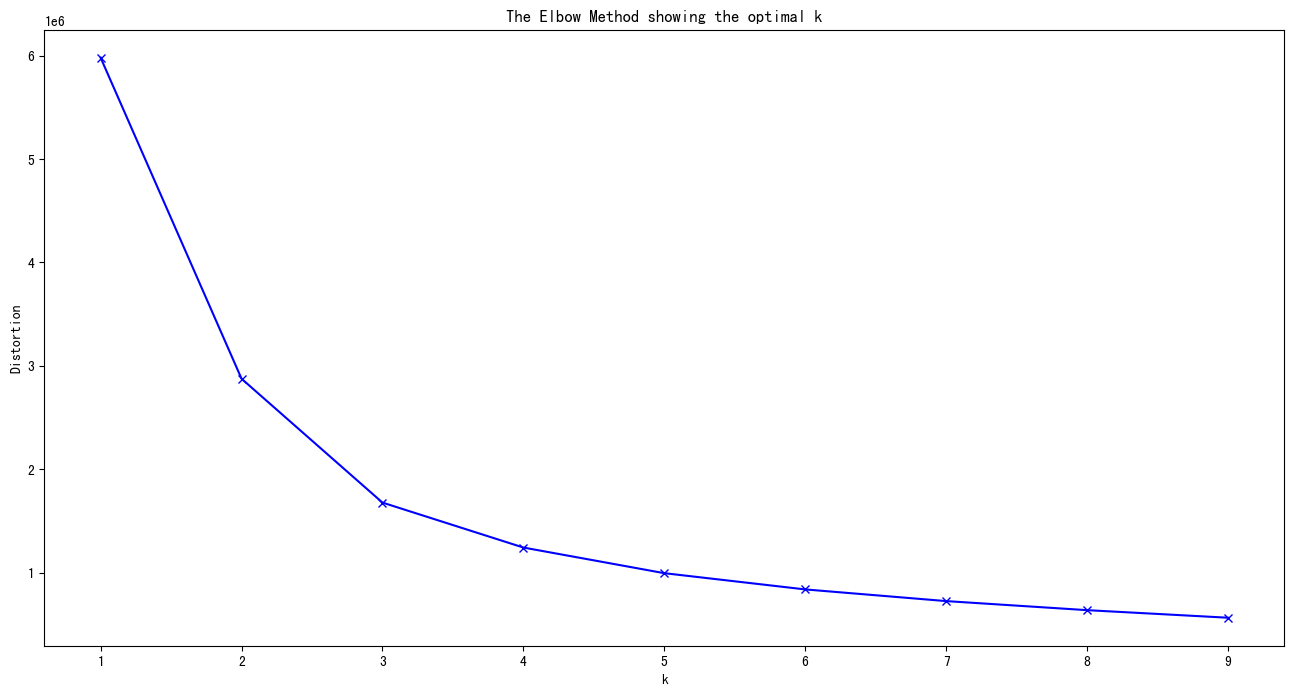

In [24]:
##elbow plot
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k)
    kmeanModel.fit(data_for_cluster)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

決定分3群

In [25]:
####分3群
kmeans_fit = cluster.KMeans(n_clusters = 3).fit(data_for_cluster)
cluster_labels_3 = kmeans_fit.labels_
df['cluster_3'] = cluster_labels_3

In [26]:
df.groupby('cluster_3').size()

cluster_3
0    3613
1    9873
2    4939
dtype: int64

In [27]:
c_df1 = df[df['cluster_3'] == 0] 
c_df2 = df[df['cluster_3'] == 1] 
c_df3 = df[df['cluster_3'] == 2] 

定義高績效業務員

In [28]:
choice = ['top25%']
condition = [c_df1.MIXED_PREMIUM >= np.nanpercentile(c_df1.MIXED_PREMIUM, 75)]
c_df1['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')
condition = [c_df2.MIXED_PREMIUM >= np.nanpercentile(c_df2.MIXED_PREMIUM, 75)]
c_df2['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')
condition = [c_df3.MIXED_PREMIUM >= np.nanpercentile(c_df3.MIXED_PREMIUM, 75)]
c_df3['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')

/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_1104/1388406250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df1['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')
/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_1104/1388406250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df2['top_PERFORMANCE'] = np.select(condition, choice, default = 'other')
/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_1104/1388406250.py:7: SettingWithCopyWarning: 
A 

In [30]:
l = LabelEncoder()

c_df1['top_PERFORMANCE'] = l.fit_transform(c_df1['top_PERFORMANCE']) 
c_df2['top_PERFORMANCE'] = l.fit_transform(c_df2['top_PERFORMANCE']) 
c_df3['top_PERFORMANCE'] = l.fit_transform(c_df3['top_PERFORMANCE']) 

/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_1104/1129587255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df1['top_PERFORMANCE'] = l.fit_transform(c_df1['top_PERFORMANCE'])
/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_1104/1129587255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df2['top_PERFORMANCE'] = l.fit_transform(c_df2['top_PERFORMANCE'])
/var/folders/93/jy5s5h4d6wb954g_5_jtd1m40000gn/T/ipykernel_1104/1129587255.py:5: SettingWithCopyWarning: 
A value is try

In [31]:
c_df1.to_excel('data/c_df1.xlsx')
c_df2.to_excel('data/c_df2.xlsx')
c_df3.to_excel('data/c_df3.xlsx')